# QHACK 2021 QML Challenges - Circuit Training

In [1]:
import json
import sys

import networkx as nx
import pennylane as qml

from pennylane import numpy as np
from matplotlib import pyplot as plt

In [2]:
np.random.seed(1967)

## Problem 1 : Optimizing a Quantum Circuit

### Helper functions

In [20]:
def parse_hamiltonian(file_name):
    """
    Parse an input file with the Hamiltonian data
    Args:
        file_name (string): Name of the file containing the Hamiltonian values
    Returns: 
        hamiltonian (np.ndarray): An array of the Hamiltonian
    """
    with open(file_name) as f:
        hamiltonian = f.read()
    hamiltonian = hamiltonian.split(",")
    hamiltonian = np.array(hamiltonian, float).reshape((2 ** WIRES, 2 ** WIRES))
    return hamiltonian

In [21]:
def parse_energy(file_name):
    """
    Parse an input file with the expected energy after optimization
    Args:
        file_name (string): Name of the file containing the value of expected energy after optimization
    Return:
        energy (float): Expected energy after optimization
    """
    with open(file_name) as f:
        energy = f.read().rstrip('\n')
    energy = round(float(energy), 8)
    return energy

![Variational Circuit](https://pennylane.readthedocs.io/en/stable/_images/layer_sec.png)

\begin{equation}
\begin{split}R(\phi,\theta,\omega) = RZ(\omega)RY(\theta)RZ(\phi)= \begin{bmatrix}
e^{-i(\phi+\omega)/2}\cos(\theta/2) & -e^{i(\phi-\omega)/2}\sin(\theta/2) \\
e^{-i(\phi-\omega)/2}\sin(\theta/2) & e^{i(\phi+\omega)/2}\cos(\theta/2)
\end{bmatrix}.\end{split}
\end{equation}

In [22]:
def variational_circuit(params):
    """
    # DO NOT MODIFY anything in this function! It is used to judge your solution.
    This is a template variational quantum circuit containing a fixed layout of gates with variable
    parameters. To be used as a QNode, it must either be wrapped with the @qml.qnode decorator or
    converted using the qml.QNode function (as shown above).
    The output of this circuit is the expectation value of a Hamiltonian. An unknown Hamiltonian
    will be used to judge your solution.
    Args:
        params (np.ndarray): An array of optimizable parameters of shape (30,)
    """
    parameters = params.reshape((LAYERS, WIRES, 3))
    qml.templates.StronglyEntanglingLayers(parameters, wires=range(WIRES))
    return qml.expval(qml.Hermitian(hamiltonian, wires=[0, 1]))

In [23]:
# DO NOT MODIFY any of these parameters
WIRES = 2
LAYERS = 5
NUM_PARAMETERS = LAYERS * WIRES * 3

In [24]:
hamiltonian = parse_hamiltonian("data/100-2.in")
print("Hamiltonian :\n", hamiltonian)

Hamiltonian :
 [[ 0.32158897 -0.20689268  0.12366748 -0.11737425]
 [-0.20689268  0.77473461 -0.05159966  0.0821554 ]
 [ 0.12366748 -0.05159966  0.57690505  0.38533629]
 [-0.11737425  0.0821554   0.38533629  0.39862567]]


In [25]:
# Initialize the device
dev = qml.device("default.qubit", wires=WIRES)

In [26]:
# Instantiate the QNode
circuit = qml.QNode(variational_circuit, dev)

In [27]:
# Instantiate the circuit optimizer
opt = qml.AdamOptimizer()

In [28]:
# Training hyper-parameters
max_iterations = 500
conv_tol = 1e-12

In [29]:
params = np.random.random(NUM_PARAMETERS)
for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(circuit, params)
    energy = circuit(params)
    if n == 0:
        print(circuit.draw())
    conv = np.abs(energy - prev_energy)

    if n % 10 == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha'.format(n, energy))

    if conv <= conv_tol:
        break

 0: ──Rot(0.229, 0.451, 0.325)──╭C──╭X──Rot(0.534, 0.58, 0.589)──────╭C──╭X──Rot(0.1, 0.886, 0.636)────╭C──╭X──Rot(0.0106, 0.113, 0.72)──╭C──╭X──Rot(0.162, 0.7, 0.838)────╭C──╭X──╭┤ ⟨H0⟩ 
 1: ──Rot(0.52, 0.382, 0.125)───╰X──╰C──Rot(0.0262, 0.96, -0.00214)──╰X──╰C──Rot(0.357, 0.923, 0.159)──╰X──╰C──Rot(0.255, 0.282, 0.783)──╰X──╰C──Rot(0.302, 0.763, 0.641)──╰X──╰C──╰┤ ⟨H0⟩ 
H0 =
[[ 0.32158897 -0.20689268  0.12366748 -0.11737425]
 [-0.20689268  0.77473461 -0.05159966  0.0821554 ]
 [ 0.12366748 -0.05159966  0.57690505  0.38533629]
 [-0.11737425  0.0821554   0.38533629  0.39862567]]

Iteration = 0,  Energy = 0.48715748 Ha
Iteration = 10,  Energy = 0.37809972 Ha
Iteration = 20,  Energy = 0.27447894 Ha
Iteration = 30,  Energy = 0.18041208 Ha
Iteration = 40,  Energy = 0.10371626 Ha
Iteration = 50,  Energy = 0.03798204 Ha
Iteration = 60,  Energy = 0.00779508 Ha
Iteration = 70,  Energy = 0.00357992 Ha
Iteration = 80,  Energy = 0.00311981 Ha
Iteration = 90,  Energy = 0.00289754 Ha
Iteration = 10

In [30]:
print(f"{energy:.8f}")

0.00246488


In [31]:
parse_energy("data/100-2.ans")

0.00246488

## Problem 2 : QAOA

![QAOA Circuit](https://pennylane.ai/qml/_images/qaoa_circuit.png)

### Helper functions

In [32]:
def parse_input_data(file_name):
    with open(file_name) as f:
        graph_string = f.read()
    graph_data = json.loads(graph_string)
    params = np.array(graph_data.pop("params"))
    graph = nx.json_graph.adjacency_graph(graph_data)
    
    return graph, params

In [33]:
def plot_graph(graph, color_map=None):
    if color_map is None:
        nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph))
    else:
        nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph), node_color=color_map)
    plt.show()

In [34]:
def parse_solution(file_name):
    with open(file_name) as f:
        solution = f.read()
    return solution

In [35]:
# DO NOT MODIFY any of these parameters
NODES = 6
N_LAYERS = 10

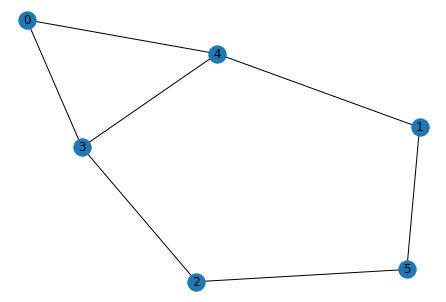

In [36]:
graph, params = parse_input_data("data/200-2.in")
plot_graph(graph)

$$H_C \ = \ \displaystyle\sum_{v \in V(G)} Z_{v},$$
where $V(G)$ is the set of vertices of the input graph, and $Z_i$ is the Pauli-Z operator applied to the i-th vertex.

The mixer hamiltonian is a bit-flip mixer applied to G :
$$H_M \ = \ \displaystyle\sum_{v \in V(G)} \frac{1}{2^{d(v)}} X_{v}
\displaystyle\prod_{w \in N(v)} (\mathbb{I} \ + \ (-1)^b Z_w)$$
where $V(G)$ is the set of vertices of some graph G, $d(v)$ is the degree of vertex $v$, and $N(v)$ is the neighbourhood of vertex $v$. In addition, $Z_v$ and $X_v$ are the Pauli-Z and Pauli-X operators on vertex $v$, respectively, and $I$ is the identity operator.

In [37]:
# fix cost and mixer hamiltonians
#https://pennylane.readthedocs.io/en/stable/code/api/pennylane.qaoa.cost.max_independent_set.html
COST_H, MIXER_H = qml.qaoa.max_independent_set(graph, constrained=True)
print("Cost_H :\n", COST_H)
print("Mixer_H :\n", MIXER_H)

Cost_H :
 (1) [Z0]
+ (1) [Z1]
+ (1) [Z2]
+ (1) [Z3]
+ (1) [Z4]
+ (1) [Z5]
Mixer_H :
 (0.25) [X0]
+ (0.25) [X0 Z4]
+ (0.25) [X0 Z3]
+ (0.25) [X0 Z3 Z4]
+ (0.25) [X1]
+ (0.25) [X1 Z5]
+ (0.25) [X1 Z4]
+ (0.25) [X1 Z4 Z5]
+ (0.25) [X2]
+ (0.25) [X2 Z5]
+ (0.25) [X2 Z3]
+ (0.25) [X2 Z3 Z5]
+ (0.125) [X3]
+ (0.125) [X3 Z4]
+ (0.125) [X3 Z2]
+ (0.125) [X3 Z2 Z4]
+ (0.125) [X3 Z0]
+ (0.125) [X3 Z0 Z4]
+ (0.125) [X3 Z0 Z2]
+ (0.125) [X3 Z0 Z2 Z4]
+ (0.125) [X4]
+ (0.125) [X4 Z3]
+ (0.125) [X4 Z1]
+ (0.125) [X4 Z1 Z3]
+ (0.125) [X4 Z0]
+ (0.125) [X4 Z0 Z3]
+ (0.125) [X4 Z0 Z1]
+ (0.125) [X4 Z0 Z1 Z3]
+ (0.25) [X5]
+ (0.25) [X5 Z2]
+ (0.25) [X5 Z1]
+ (0.25) [X5 Z1 Z2]


In [38]:
# apply time evolution by building cost and mixer layers
# inputs are the Hamiltonians above and parameters to optimise
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, COST_H)
    qml.qaoa.mixer_layer(alpha, MIXER_H)

In [39]:
# Initialize the device
dev = qml.device("default.qubit", wires=NODES)

# the actual QAOA variational circuit N_LAYERS repetitions of qaoa_layer
@qml.qnode(dev)
def circuit(params):
    qml.layer(qaoa_layer, N_LAYERS, params[0], params[1])
    return qml.probs(wires=range(NODES))

In [48]:
params[0], params[1]

(tensor([ 7.25119586e-03,  6.99314655e-04,  1.89386530e-04,
         -2.57669494e-03,  1.84128567e-04,  7.97171577e-04,
         -1.47403023e-03,  1.13345313e-03,  4.74850944e-03,
         -2.71981989e-05], requires_grad=True),
 tensor([0.02350176, 0.04041058, 0.10033414, 0.18915211, 0.24644283,
         0.20388889, 0.12928228, 0.06257051, 0.04319572, 0.02744075], requires_grad=True))

In [40]:
#get the probabilities of each basis state
probs = circuit(params)
print(circuit.draw())

 0: ──RZ(0.0145)──H──RZ(0.0118)──H──H───────────────╭RZ(0.0118)──H──H──╭RZ(0.0118)──H──H──╭RZ(0.0118)───H───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╭RZ(0.00588)────────╭RZ(0.00588)────────╭RZ(0.00588)────────╭RZ(0.00588)─────────────────────────────────────────────────────────────────────────────────────────────────╭RZ(0.00588)────────╭RZ(0.00588)────────╭RZ(0.00588)────────╭RZ(0.00588)──RZ(0.0014)───────────────H───────────RZ(0.0202)───H───────────H───────────────────────╭RZ(0.0202)──H───────────H─────╭RZ(0.0202)───H───────────H─────╭RZ(0.0202)───H───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╭RZ(0.0101)────────╭RZ(0.0101)────────╭RZ(0.0101)────────╭RZ(0.0101)─────────────────────────────────────────────────────────────────────────────────────────────╭RZ(0

[2.93486761e-03 3.57650613e-02 3.56497397e-04 7.55835659e-02
 2.48650371e-05 1.02613664e-01 2.94769205e-33 3.72016466e-32
 1.07952333e-02 1.39155962e-32 1.24453740e-01 3.00926554e-36
 5.83515396e-33 7.73381243e-34 3.08449718e-33 6.07864704e-64
 1.17440439e-02 3.90677898e-33 1.40323933e-32 7.71124294e-34
 1.32484278e-01 3.77753103e-32 1.92713365e-32 1.36917927e-63
 3.52900304e-02 3.08224023e-33 2.36603503e-33 3.63205466e-64
 8.31309605e-34 2.19585004e-65 5.99407714e-65 5.13887131e-97
 8.87385088e-03 9.82698698e-02 6.91173287e-34 2.75304712e-32
 1.13380255e-32 3.89537606e-32 3.63364005e-64 1.43610291e-64
 3.61165424e-02 1.62007572e-31 3.22894192e-33 5.65579754e-64
 1.92713365e-32 1.66765909e-64 8.34571384e-66 2.30255957e-94
 3.57943124e-02 4.87576249e-33 1.88079096e-35 9.97556370e-64
 7.26511933e-33 1.36973565e-63 1.37685732e-63 3.04308963e-95
 2.88899578e-01 1.20370622e-35 3.51482215e-33 3.41840439e-64
 1.20370622e-35 9.82736783e-66 1.66097690e-64 1.87267054e-96]


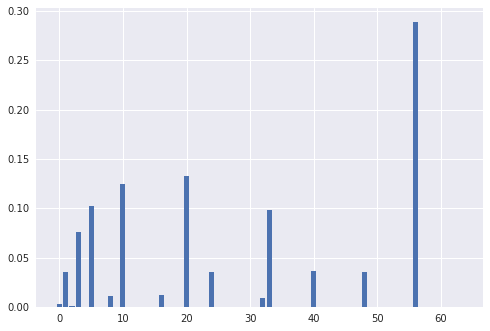

56 111000


In [46]:
print(probs)

plt.style.use("seaborn")
plt.bar(range(2 ** NODES), probs)
plt.show()

print(np.argmax(probs), format(np.argmax(probs), "06b"))

In [42]:
max_ind_set = []

#convert to bitstring and get positions of 1-bits   
bitstring=np.argmax(probs)
lex_bitstring=format(bitstring, "06b")

color_map = ["blue" for i in range(NODES)]
for i,b in enumerate(lex_bitstring):
    if int(b)==1:
        max_ind_set.append(i)
        color_map[i] = "red"

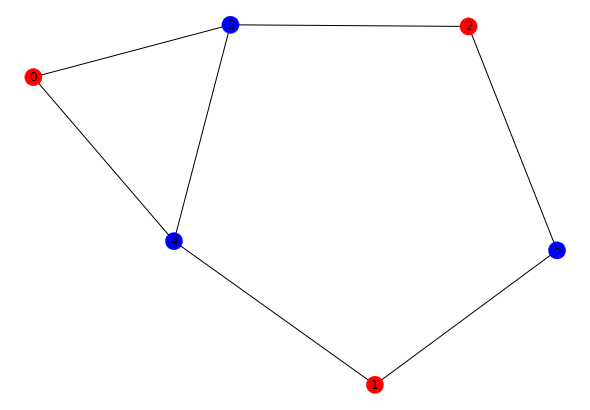

[0, 1, 2]


In [43]:
plot_graph(graph, color_map=color_map)
print(max_ind_set)

In [44]:
parse_solution("data/200-2.ans")

'[0, 1, 2]'

## Problem 3 : Variational Quantum Classifier

### Helper functions

In [49]:
def array_to_concatenated_string(array):
    """DO NOT MODIFY THIS FUNCTION.
    Turns an array of integers into a concatenated string of integers
    separated by commas. (Inverse of concatenated_string_to_array).
    """
    return ",".join(str(x) for x in array)

In [50]:
def concatenated_string_to_array(string):
    """DO NOT MODIFY THIS FUNCTION.
    Turns a concatenated string of integers separated by commas into
    an array of integers. (Inverse of array_to_concatenated_string).
    """
    return np.array([int(x) for x in string.split(",")])

In [51]:
def parse_input(file_name):
    """DO NOT MODIFY THIS FUNCTION.
    Parse the input data into 3 arrays: the training data, training labels,
    and testing data.
    Dimensions of the input data are:
      - X_train: (250, 3)
      - Y_train: (250,)
      - X_test:  (50, 3)
    """
    with open(file_name) as f:
        giant_string = f.read()
    X_train_part, Y_train_part, X_test_part = giant_string.split("XXX")

    X_train_row_strings = X_train_part.split("S")
    X_train_rows = [[float(x) for x in row.split(",")] for row in X_train_row_strings]
    X_train = np.array(X_train_rows)

    Y_train = concatenated_string_to_array(Y_train_part)

    X_test_row_strings = X_test_part.split("S")
    X_test_rows = [[float(x) for x in row.split(",")] for row in X_test_row_strings]
    X_test = np.array(X_test_rows)

    return X_train, Y_train, X_test

### Classify data

In [52]:
# Use this array to make a prediction for the labels of the data in X_test
predictions = []

# Hyperparameters
WIRES = 3
LAYERS = 3
BATCH_SIZE = 5
N_ITER = 80

# Instantiate the optimizer
opt = qml.AdamOptimizer()

# Initialize the device
dev = qml.device("default.qubit", wires=WIRES)

In [53]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 0])

In [54]:
@qml.qnode(dev)
def circuit(weights, x=None):
    qml.QubitStateVector(x, wires=[0, 1])

    for W in weights:
        layer(W)

    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

In [55]:
def variational_classifier(var, angles):
        weights = var[0]
        bias = var[1]
        return circuit(weights, x=angles) + bias

In [56]:
def one_hot(lbl):
    ret = None
    if lbl == -1:
        ret = [-1, 1, 1]
    elif lbl == 0:
        ret = [1, -1, 1]
    else:
        ret = [1, 1, -1]
    return np.array(ret)

In [57]:
def one_hot_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        l = one_hot(l)
        loss = loss + np.sum((l - p)**2)

    loss = loss / len(labels)
    return loss

In [58]:
def cost(weights, features, labels):
    predictions = [variational_classifier(weights, f) for f in features]
    return one_hot_loss(labels, predictions)

In [59]:
def discretize(out):
    return np.argmin(out, axis=1)-1

In [60]:
X_train, Y_train, X_test = parse_input("data/500-1.in")

In [61]:
print("Input :\n", X_train[:6], "\nLabels :\n", Y_train[:6])

Input :
 [[ 0.46586604  0.47378893  0.22608081]
 [ 0.32045034  0.26276939  0.12634708]
 [-0.2470099   0.11383845  0.14686661]
 [-0.39945595  0.12837791  0.16662385]
 [-0.33023235 -0.12453634  0.19838102]
 [ 0.0389054  -0.69261027 -1.21261411]] 
Labels :
 [-1 -1  0  0  0  1]


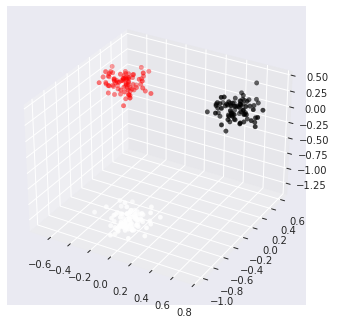

In [62]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color_map = np.array(["red", "white", "black"])
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=color_map[Y_train])
plt.show()

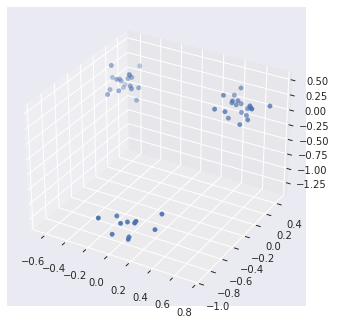

In [63]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color_map = np.array(["red", "white", "black"])
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2])
plt.show()

In [64]:
# Pad zero to the last dimension to use 2 wires
# Source : https://pennylane.ai/qml/demos/tutorial_variational_classifier.html
X_train_pad = np.c_[X_train, np.zeros((len(X_train), 1))]
X_test_pad = np.c_[X_test, np.zeros((len(X_test), 1))]

In [65]:
# Normalization
# Source : https://pennylane.ai/qml/demos/tutorial_variational_classifier.html
train_norm = np.sqrt(np.sum(X_train_pad ** 2, 1))
test_norm = np.sqrt(np.sum(X_test_pad ** 2, 1))

X_train_norm = (X_train_pad.T / train_norm).T
X_test_norm = (X_test_pad.T / test_norm).T

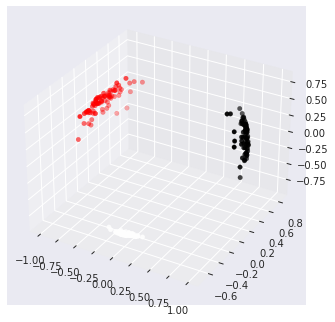

In [66]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color_map = np.array(["red", "white", "black"])
ax.scatter(X_train_norm[:, 0], X_train_norm[:, 1], X_train_norm[:, 2], c=color_map[Y_train])
plt.show()

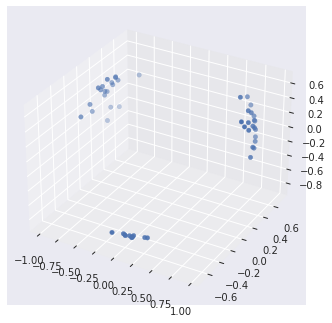

In [67]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color_map = np.array(["red", "white", "black"])
ax.scatter(X_test_norm[:, 0], X_test_norm[:, 1], X_test_norm[:, 2])
plt.show()

In [68]:
# Source : https://pennylane.ai/qml/demos/tutorial_variational_classifier.html
var = (0.01 * np.random.randn(LAYERS, WIRES, 3), 0.0)
for it in range(N_ITER):
    batch_index = np.random.randint(0, len(X_train), (BATCH_SIZE,))
    X_batch = X_train_norm[batch_index]
    Y_batch = Y_train[batch_index]

    var, opt_cost = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch), var)
    train_predictions = discretize(np.array([variational_classifier(var, f) for f in X_batch]))
    acc = np.sum(train_predictions == Y_batch)/BATCH_SIZE
    
    if it % 5 == 0:
        print('Iteration = {:},  Cost = {:.4f}, Accuracy = {:.4f}'.format(it, opt_cost, acc))

Iteration = 0,  Cost = 4.2172, Accuracy = 0.8000
Iteration = 5,  Cost = 4.0142, Accuracy = 0.8000
Iteration = 10,  Cost = 3.3584, Accuracy = 0.2000
Iteration = 15,  Cost = 3.6582, Accuracy = 0.8000
Iteration = 20,  Cost = 3.6623, Accuracy = 0.4000
Iteration = 25,  Cost = 3.5658, Accuracy = 0.8000
Iteration = 30,  Cost = 3.7891, Accuracy = 0.8000
Iteration = 35,  Cost = 3.0463, Accuracy = 0.8000
Iteration = 40,  Cost = 3.2001, Accuracy = 0.8000
Iteration = 45,  Cost = 2.7102, Accuracy = 0.8000
Iteration = 50,  Cost = 2.4628, Accuracy = 0.8000
Iteration = 55,  Cost = 2.3785, Accuracy = 1.0000
Iteration = 60,  Cost = 2.2256, Accuracy = 0.8000
Iteration = 65,  Cost = 1.9873, Accuracy = 1.0000
Iteration = 70,  Cost = 2.0335, Accuracy = 1.0000
Iteration = 75,  Cost = 1.8986, Accuracy = 1.0000


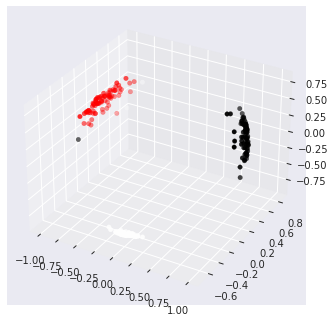

In [69]:
train_predictions = discretize(np.array([variational_classifier(var, f) for f in X_train_norm]))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color_map = np.array(["red", "white", "black"])
ax.scatter(X_train_norm[:, 0], X_train_norm[:, 1], X_train_norm[:, 2], c=color_map[train_predictions])
plt.show()

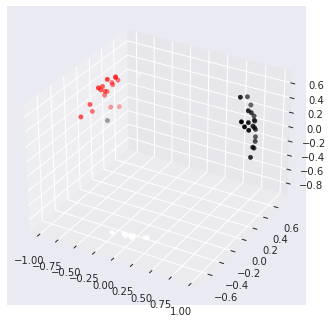

In [70]:
test_predictions = discretize(np.array([variational_classifier(var, f) for f in X_test_norm]))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color_map = np.array(["red", "white", "black"])
ax.scatter(X_test_norm[:, 0], X_test_norm[:, 1], X_test_norm[:, 2], c=color_map[test_predictions])
plt.show()